In [1]:
import sys

sys.path.insert(0, "/Users/spoelsterl/Projects/aimed/abcd_paper")

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

import src.data.var_names as var_names
from definitions import REPO_ROOT, PROCESSED_DATA_DIR, RAW_DATA_DIR, RESULTS_DIR

In [3]:
abcd_data = pd.read_csv(PROCESSED_DATA_DIR / 'abcd_data.csv')
abcd_data = abcd_data.dropna()  # NaNs are dropped in the study in the RepeatedStratifiedKFoldDataloader

In [4]:
# Define plotting variables
main_color = (0x63/255, 0x63/255, 0x63/255)
label_size = 24
tick_size = 18
# tick_rotation = 45
annotation_size = 13

params = {
    "axes.labelsize": label_size,
    "xtick.labelsize": tick_size,
    "ytick.labelsize": tick_size,
    'legend.fontsize': 15,
    'legend.title_fontsize': tick_size,
    "savefig.transparent": True,
    'axes.labelpad': 10.0,
    'svg.fonttype': 'none' # Takes care that texts show up when importing pdf-plots into Inkcape
}

plt.rcParams.update(params)

## Make prevalence and concordance chart

In [5]:
from typing import Optional

from matplotlib.ticker import PercentFormatter


class PrevalencePlot:
    def __init__(self, data: pd.DataFrame, sort_by_prev: bool = True) -> None:
        """
        :type data: pandas.DataFrame
        :param label: Label of the data
        :type label: str
        :param sort_by_prev: Whether to sort columns by
        prevalence of concordance instance
        """
        assert not data.isnull().sum().any()
        self.data = data.astype(int)
        self.sort_by_prev = sort_by_prev

    def get_prevalences(self) -> pd.DataFrame:
        counts = self.data.sum(axis=0)
        percentage = counts / self.data.shape[0]

        df = pd.DataFrame({"Count": counts, "Percent": percentage})
        return df

    def get_combinations(self) -> pd.DataFrame:
        miss_patterns = self.data.agg(
            lambda x: ":".join(map(str, x)), axis=1
        )
        counts = miss_patterns.value_counts()
        percentage = counts / self.data.shape[0]

        df = pd.DataFrame({"Count": counts, "Percent": percentage})
        assert df["Count"].sum() == self.data.shape[0]

        mindex = df.index.str.split(":", expand=True)
        mindex.names = self.data.columns
        df.index = mindex
        return df
    
    def plot_prevalance(
        self,
        drop_all_zero: bool = True,
        max_patterns: Optional[int] = None,
        bar_width: float = 0.8,
        **fig_kws,
    ) -> None:
        """Plot combinations of diagnoses"""
        prevs = self.get_prevalences()
        combs = self.get_combinations()

        if drop_all_zero:
            combs.drop(("0",) * prevs.shape[0], inplace=True)

        if self.sort_by_prev:
            prevs.sort_values(by="Count", ascending=False, inplace=True)
            combs.index = combs.index.reorder_levels(order=prevs.index.tolist())
            combs.sort_values(by="Count", ascending=False, inplace=True)

        n_excluded_combs = 0
        if max_patterns is not None:
            n_excluded_combs = combs.shape[0] - max_patterns
            excluded_combs = combs.iloc[max_patterns:].sum()
            combs = combs.head(max_patterns)

#         print(excluded_combs)
#         print(combs.Peercent)

        pal = sns.color_palette("Set1", n_colors=prevs.shape[0])
        pal[5], pal[7] = pal[7], pal[5]  # swap colors
        color_inactive = (0xE7 / 255, 0xE7 / 255, 0xE7 / 255)
        
        x_coords = np.arange(prevs.shape[0], dtype=int)
        y_coords = np.arange(combs.shape[0], dtype=int)

        tick_formatter = PercentFormatter(1.0, 0)

        fig = plt.figure(constrained_layout=True, **fig_kws)
        gs = fig.add_gridspec(nrows=2, ncols=2, wspace=0.0, hspace=0.0, height_ratios=(1, 2))
        ax_top = fig.add_subplot(gs[0, 0])
        ax_mid = fig.add_subplot(gs[1, 0], sharex=ax_top)
        ax_right = fig.add_subplot(gs[1, 1], sharey=ax_mid)

        # top
        legend_handles = []
        legend_labels = []
        for (name, value), x, color in zip(prevs.loc[:, "Percent"].iteritems(), x_coords, pal):
            rect = ax_top.bar(x, value, width=bar_width, color=color, label=name, zorder=3)
            ax_top.annotate(
                "{:.1f}%".format(value * 100),
                (x, value),
                xytext=(0, 6),
                textcoords="offset points",
                ha="center",
                size=annotation_size,
            )
            legend_handles.append(rect)
            legend_labels.append(name)

        ax_top.set_ylabel("Prevalence")
        ax_top.yaxis.grid(True)
        ax_top.yaxis.set_major_formatter(tick_formatter)
        ax_top.xaxis.set_visible(False)

        # legend
        fig.legend(
            legend_handles,
            legend_labels,
            loc="upper right",
            bbox_to_anchor=(0.98, 0.975),
            title="Disorders",
        )

        # mid
        ax_mid.set_ylim(-0.5, y_coords[-1] + 0.5)

        for i, row in enumerate(combs.itertuples()):
            y = y_coords[-1] - i
            marked = []
            for j, label in enumerate(row.Index):
                if label == '1':  # it's active
                    color = pal[j]
                    zorder = 3
                    marked.append(j)
                else:
                    color = color_inactive
                    zorder = 1

                ax_mid.plot(j, y, marker="o", markersize=25, color=color, zorder=zorder)

            if len(marked) > 0:
                ax_mid.plot([min(marked), max(marked)], [y, y], '-', color="black", linewidth=4, zorder=2)

        ax_mid.set_xticks(x_coords)
#         ax_mid.set_xticklabels(prevs.index.tolist(), rotation=45, rotation_mode='anchor', ha='right')
        ax_mid.xaxis.set_visible(False)

        ax_mid.yaxis.set_visible(False)

        ax_mid.text(
            -0.10, 0.5,
            "Combinations",
            rotation="vertical",
            transform=ax_mid.transAxes,
            va="center",
            size=label_size,
        )

        # right
        ax_right.barh(
            y_coords[::-1],
            combs.loc[:, "Percent"].values,
            height=bar_width,
            color=main_color,
            zorder=3,
        )
        for y, value in zip(y_coords[::-1], combs.loc[:, "Percent"].values):
            ax_right.annotate(
                "{:.1f}%".format(value * 100),
                (value, y),
                xytext=(6, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                size=annotation_size,
            )

#         ax_right.yaxis.tick_right()
        ax_right.yaxis.set_visible(False)
        ax_right.xaxis.grid(True)
        ax_right.xaxis.set_major_formatter(tick_formatter)
        ax_right.set_xlabel("Prevalence of Combination")

        # extra combinations that are not displayed
        if n_excluded_combs > 0:
            value = excluded_combs.loc["Percent"]
            ax_right.barh(
                -1,
                value,
                height=bar_width,
                color=main_color,
                alpha=0.5,
            )
            ax_right.annotate(
                "{:.1f}%".format(value * 100),
                (value, -1),
                xytext=(6, 0),
                textcoords="offset points",
                ha="left",
                va="center",
                size=annotation_size,
            )

            start, end = ax_mid.get_ylim()
            ax_mid.set_ylim(start - 1, end)
            ydots = np.linspace(-0.65, -1.15, 3)
            for x in (0, x_coords[-1]):
#                 ax_mid.arrow(x, -0.65, 0, -.95, width=0.2, head_length=0.3, facecolor='black')
                ax_mid.scatter([x] * ydots.shape[0], ydots, marker=".", color="black")

            ax_mid.text(
                x_coords[-1] / 2,
                ydots[1],
                f"{n_excluded_combs} more combinations",
                ha="center",
                va="center",
                size=annotation_size,
            )

        ax_right.set_xlim(0, ax_right.get_xlim()[1] + 0.01)
        ax_top.set_ylim(0, ax_top.get_ylim()[-1] + 0.01)

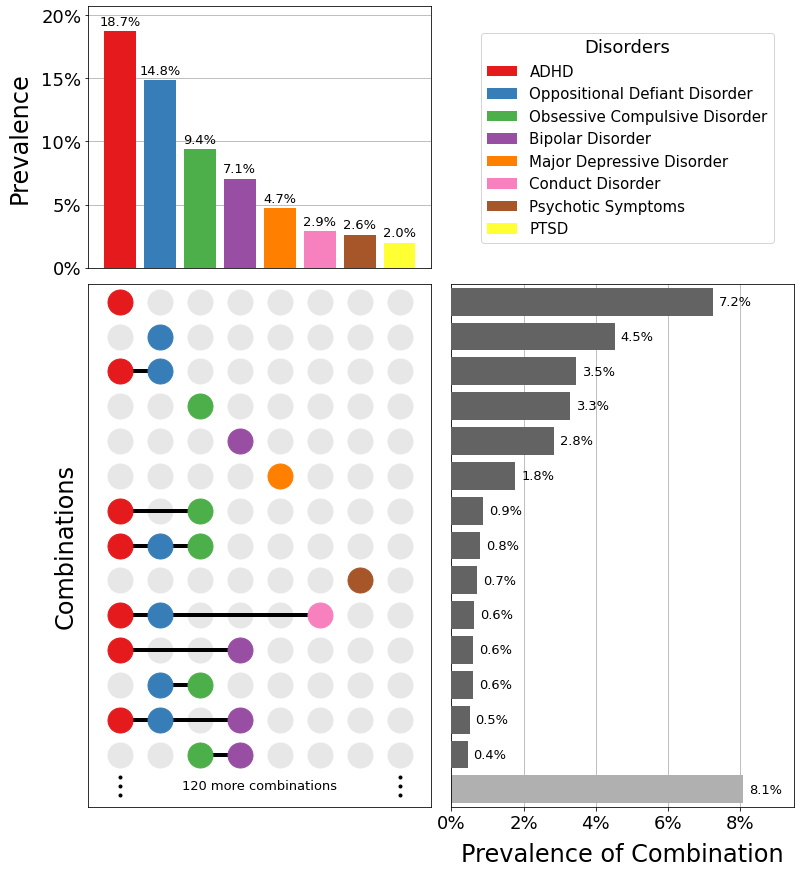

In [6]:
cp = PrevalencePlot(
    abcd_data[var_names.diagnoses.features],
    sort_by_prev=True
)

cp.plot_prevalance(max_patterns=14, figsize=(11, 12))

plt.savefig("combinations.pdf", transparent=True, bbox_inches="tight", dpi=300)